# Kotug Project, Group 1

Allan Guzman, June Chen, Sarah Blanc

(Please make sure to first read the file called "README.md". It helps to get the main story line of what we did and the organization of the files.)

Let's maybe first remember here the research questions of this project:

## **Main Research Question**:

"How can the reliability and efficiency of Kotug OptiPort's tugboat scheduling tool be enhanced through the development and evaluation of novel methods for predicting pickup and drop-off coordinates and other relevant variables?"

## **Subresearch Questions**:

- "What advanced predictive methods can be developed and implemented to accurately forecast the coordinates (latitude and longitude) for pickup and drop-off locations of tugs on vessels in the port of Rotterdam?"
- "Which variables, including AIS data, customer requirements, and port-specific constraints (or lack thereof), play a significant role in determining the pickup and drop-off locations and timing of tugs, as well as the required number of tugs for each vessel operation in the port of Rotterdam, and why are they important?"
- If there is still enough time: "Which of the above mentioned variables can be combined in order to increase the reliability of the results, and why can they be combined?". If time is missing, the aim is to at least, think about potential combinations or additional variables that could be added to the data.

The work on this first research question in done in this file, while the 2 other subquestions are answered in the file called "Data_preparation". Finally, this file also contains the conclusion of this project (see end of the file).


# Predictions

Literature review that explains the path followed through the different methods used:

As part of our effort to answer the first research question and to identify appropriate techniques for geospatial data processing, we painstakingly carried out a literature research. There were two goals in mind: finding viable approaches and understanding how they may be used in the field. Our investigation produced important findings that shaped our methodology. The key findings were the following:
1. Integrated prediction over isolated coordinates: We could have been tempted at first to use several regression models to predict latitude and longitude independently. The literature, however, strongly advises against this practise. Researchers and academics often advise against this segmentation. This advice is supported by the fact that latitude and longitude have complex interactions that are difficult to fully comprehend when viewed as separate concepts. As a result, we began to concentrate on holistic approaches that take into account all of these factors at once.
2. The potential of decision tree classifiers on our discretized polygon of water: Among the methods for classifying our data that showed promise was the decision tree classifier, especially when it came to pick-up and drop-off location prediction. It is not without restrictions, despite its potential. Indeed, we could use it, however we should create a dependence between squares (notable squares that are close to each other as an example). This could be done via new variables that we do not have. Developping them would be too complicated to apply in this project. Furthermore, its failure to adequately incorporate the geospatial nuances of our scenario is a major limitation. This insight drove us to read more in the literature and look for techniques that include the geographical dimension from the beginning. However, you can still see the results from this first method below.  
3. We reached the consensus that it's essential to reconsider approaches that don't rely on our discretized polygon. This broader perspective ensures we're not confined by our initial decision to go for this polygon. Following a brainstorming session and further reading of papers, we determined that a mixed approach with both areas and trajectories could be benefitial for the project


## Import the required librairies

In [409]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
import re
import seaborn as sn

import folium
import rasterio
import rasterio.mask

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from geopy.distance import geodesic
import folium

from shapely.geometry import Point, Polygon, LineString
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from pyproj import Geod

## Import raw data

In [410]:
incoming_weather_size_draught = gpd.read_file('Data/Input_ML/incoming_weather_size_draught.geojson')
incoming_weather_size = gpd.read_file('Data/Input_ML/incoming_weather_size.geojson')
incoming_weather = gpd.read_file('Data/Input_ML/incoming_weather.geojson')

In [411]:
havens = list(incoming_weather_size_draught['to_haven'].unique())

In [412]:
incoming_weather_size.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5430 entries, 0 to 5429
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   area_ID              5430 non-null   int64              
 1   center               5430 non-null   object             
 2   from                 5430 non-null   object             
 3   from_rounded         5430 non-null   datetime64[ns, UTC]
 4   to_haven             5430 non-null   object             
 5   vessel_mmsi          5430 non-null   int64              
 6   area                 5430 non-null   object             
 7   distance             5430 non-null   float64            
 8   Wind_Direction_Cat1  5430 non-null   object             
 9   Wind_Direction_Cat2  5430 non-null   object             
 10  Wind_Speed           5430 non-null   int64              
 11  Wind_Direction       5430 non-null   int64              
 12  Lenght      

In [413]:
leaving_weather_size_draught = gpd.read_file('Data/Input_ML/leaving_weather_size_draught.geojson')
leaving_weather_size = gpd.read_file('Data/Input_ML/leaving_weather_size.geojson')
leaving_weather = gpd.read_file('Data/Input_ML/leaving_weather.geojson')

In [414]:
leaving_weather_size_draught.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   area_ID              2293 non-null   int64              
 1   center               2293 non-null   object             
 2   to                   2293 non-null   object             
 3   to_rounded           2293 non-null   datetime64[ns, UTC]
 4   from_haven           2293 non-null   object             
 5   vessel_mmsi          2293 non-null   int64              
 6   area                 2293 non-null   object             
 7   distance             2293 non-null   float64            
 8   Wind_Direction_Cat1  2293 non-null   object             
 9   Wind_Direction_Cat2  2293 non-null   object             
 10  Wind_Speed           2293 non-null   int64              
 11  Wind_Direction       2293 non-null   int64              
 12  Lenght      

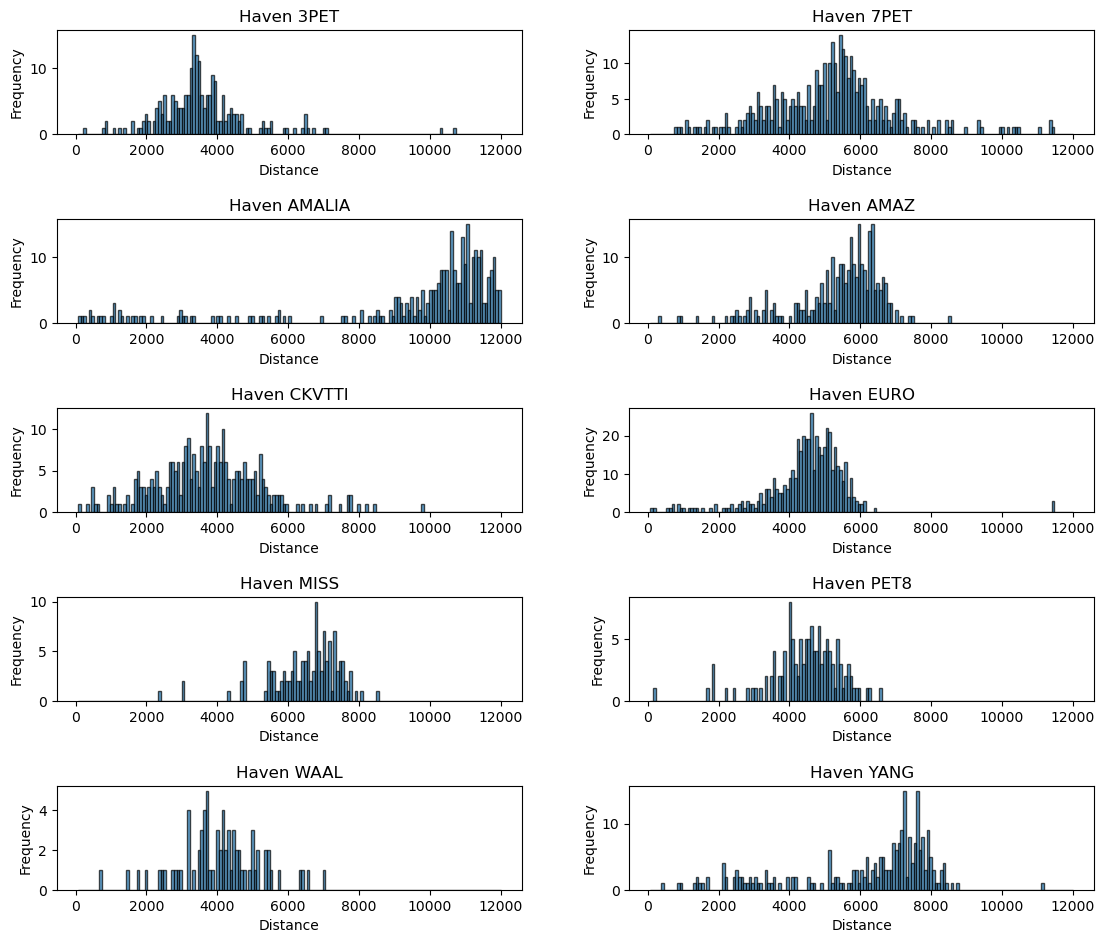

In [415]:
# Create 10 subplots for the histograms
fig, axs = plt.subplots(5, 2, figsize=(12, 10))
fig.tight_layout(pad=4.0)  # Adjust the padding between subplots

# Define the bins for the histogram
bins = range(75, 12001, 75)

# Group the DataFrame by the 'haven' column
grouped = incoming_weather_size_draught.groupby('to_haven')

# Iterate through each group and create a histogram
for i, (haven, group) in enumerate(grouped):
    row, col = i // 2, i % 2  # Determine the row and column for the subplot
    axs[row, col].hist(group['distance'], bins=bins, edgecolor='k', alpha=0.7)
    axs[row, col].set_title(f'Haven {haven}')
    axs[row, col].set_xlabel('Distance')
    axs[row, col].set_ylabel('Frequency')

plt.show()


Here above is the graphical representation of the frequency of the pick-up locations for each top-10 harbour in relation to the distance to the harbour location (in meters). The graphs show that the pick-up locations are mostly regularly. Almost each of them could be approximated by the a Gaussian, with a characteristic symmetric "bell curve" shape. 

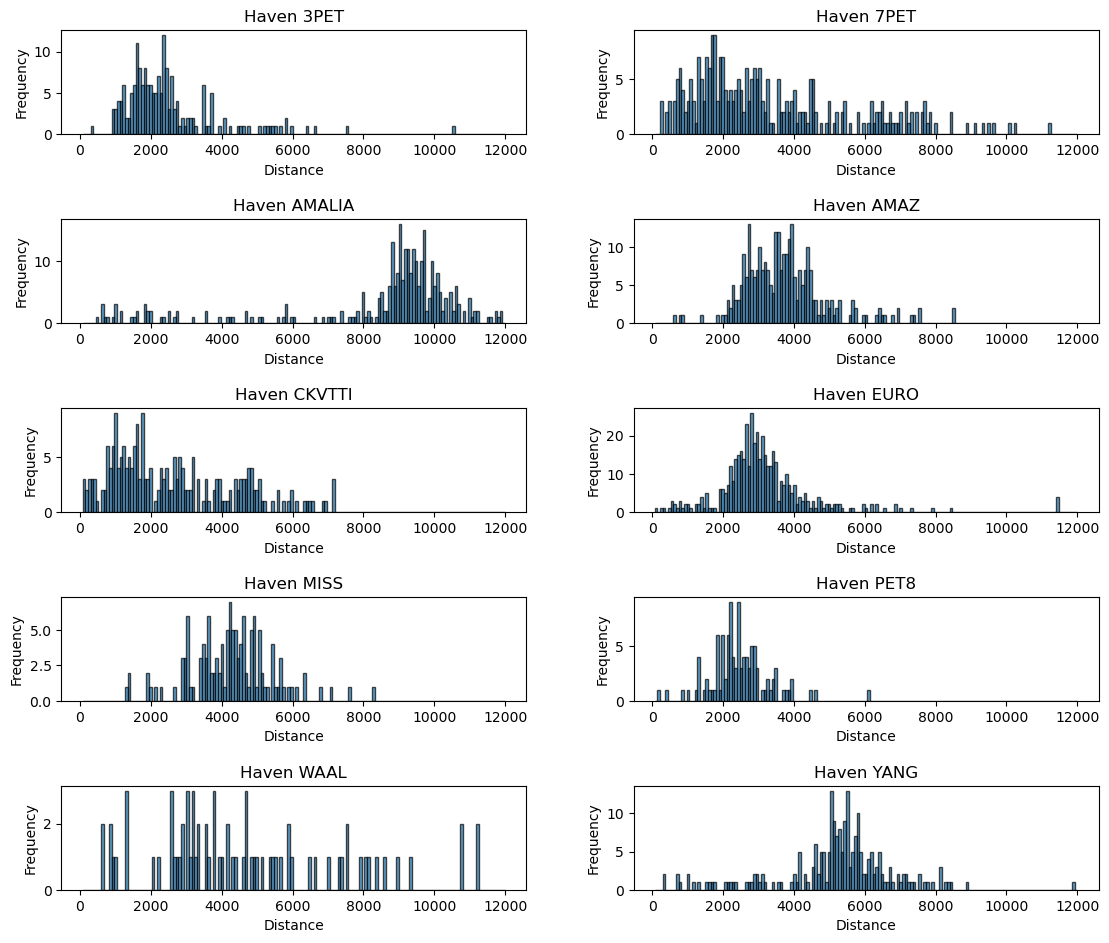

In [416]:
# Create 10 subplots for the histograms
fig, axs = plt.subplots(5, 2, figsize=(12, 10))
fig.tight_layout(pad=4.0)  # Adjust the padding between subplots

# Define the bins for the histogram
bins = range(75, 12001, 75)

# Group the DataFrame by the 'haven' column
grouped = leaving_weather_size_draught.groupby('from_haven')

# Iterate through each group and create a histogram
for i, (haven, group) in enumerate(grouped):
    row, col = i // 2, i % 2  # Determine the row and column for the subplot
    axs[row, col].hist(group['distance'], bins=bins, edgecolor='k', alpha=0.7)
    axs[row, col].set_title(f'Haven {haven}')
    axs[row, col].set_xlabel('Distance')
    axs[row, col].set_ylabel('Frequency')

plt.show()


Here above is the graphical representation of the frequency of the drop-off locations for each top-10 harbour in relation to the distance to the harbour location (in meters). It is interesting to remark that the drop-off locations is less regularly located at the same distance from the harbour. This is clearly visible with the haven "WAAL", where the drop-off locations are spread all over the path to the haven.

The correlations among the variables can be seen below.

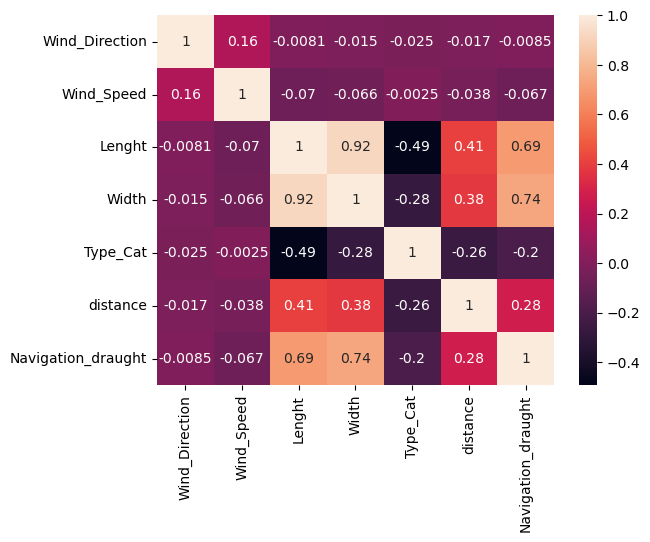

In [ ]:
corr_matrix_incoming = incoming_weather_size_draught[columns_incoming_trajectories]
corr_matrix_incoming = corr_matrix_incoming.drop(columns = 'to_haven').corr()
sn.heatmap(corr_matrix_incoming, annot=True)
plt.show()

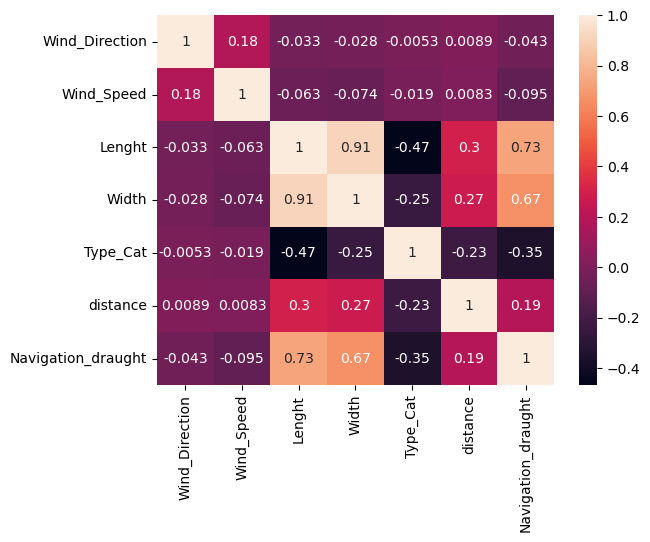

In [ ]:
corr_matrix_leaving = leaving_weather_size_draught[columns_leaving_trajectories]
corr_matrix_leaving = corr_matrix_leaving.drop(columns = 'from_haven').corr()
sn.heatmap(corr_matrix_leaving, annot=True)
plt.show()

For both leaving and incoming, we can draw the same conclusions. Firstly, one can see a high correlation between the dimensions. Indeed, the data shows that the length and the width are positively correlated: the longer, the wider. Furthermore, the length and width are also positively correlated with the draught. Bigger vessels tend to have higher draught. Finally, there is a low correlation between the wind and all the other variables. 

# **Trajectories approach**

In [417]:
# Columns that will be used for the predictions
columns_leaving_trajectories = [
    'from_haven',
    'Wind_Direction',
    'Wind_Speed',
    'Lenght',
    'Width',
    'Type_Cat',
    'distance',
    'Navigation_draught'
]

columns_incoming_trajectories = [
    'to_haven',
    'Wind_Direction',
    'Wind_Speed',
    'Lenght'	,
    'Width'	,
    'Type_Cat',
    'distance',
    'Navigation_draught'
]

Random Forest Regressor is an ensemble learning method based on the decision tree algorithm. It operates by constructing multiple decision trees during training and outputs the average prediction of the individual trees for regression tasks. In the context of assigning pick-up and drop-off locations to vessels following a trajectory, using a Random Forest Regressor offers several advantages:
1. Handling non-linearity: The random forest method can capture complex, nonlinear relationships in the data, making them suitable for predicting pick-up and drop-off locations;
2. Ensemble learning: Random Forest is an ensemble learning technique, meaning it combines predictions from multiple individual decision trees. This ensemble approach often leads to more accurate and stable predictions compared to a single decision tree. 
3. Robustness to Overfitting: Random Forests are inherently resistant to overfitting, a common challenge in complex modeling tasks. By aggregating predictions from multiple trees, it tends to generalize better to unseen data, ensuring robust and reliable predictions for vessel locations.
4. Feature importance: this method provides a natural way to rank the importance of input features. Understanding which variables significantly influence pick-up and drop-off locations is crucial for decision-making.
5. Handling multiple variables: Random Forests can handle diverse types of data, including numerical and categorical variables. 
6. Outlier resistance: This method is less sensitive to outliers due to the averaging effect from multiple trees.

## Trajectories approach: Random forests

In [420]:
# definition of the Random forest function that is going to be used many time in the following code
def Random_forest(grouped_df, haven, grouped = 1):
    if grouped == 1:
        haven_df = grouped_df.loc[haven]
    else:
        haven_df = grouped_df

    X = haven_df.drop(columns= 'distance')
    y = haven_df['distance'] 

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, min_samples_split = 10,random_state=42, criterion = 'absolute_error')
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)

    # Add the predicted distances to the original DataFrame
    X_test['predicted_distance'] = y_pred

    X_test['original_distance'] = y_test
    X_test['diff_dist'] = abs(X_test['predicted_distance']  - X_test['original_distance'])
    
    average_diff = X_test['diff_dist'].mean()
    mse = r2_score(y_test, y_pred)
    values = [average_diff]
    columns = ['avg_diff']

    # You can also access feature importances
    feature_importances = rf_model.feature_importances_.tolist()

    values.extend(feature_importances)

    columns.extend(X.columns)
    if grouped == 1:
        values.extend([haven])
        columns.extend(['haven'])
    

    output = pd.DataFrame([values], columns=columns)

    return output, X_test



### Prediction for Incoming all variables

In [421]:
incoming_trajectories = incoming_weather_size_draught[columns_incoming_trajectories]
incoming_per_haven = pd.DataFrame(incoming_trajectories['to_haven'].value_counts())
incoming_per_haven.reset_index(inplace=True)
incoming_trajectories = incoming_trajectories.groupby('to_haven').apply(lambda x: x).drop(columns = 'to_haven')

In [422]:
# Data frame to get an overview of the results and the feature importance
incoming_pred_forest = []
incoming_overall_avg = []
for haven in havens:
    avg_diff, pred = Random_forest(incoming_trajectories, haven)
    incoming_overall_avg.extend(list(pred['diff_dist']))
    incoming_pred_forest.append(avg_diff)

# Overall Average distance between predicted and real locations
print("Average distance between predicted and real locations: ", sum(incoming_overall_avg)/len(incoming_overall_avg), "meters")
incoming_pred_forest = pd.concat(incoming_pred_forest).reset_index(drop= True)

incoming_pred_forest = incoming_pred_forest.merge(incoming_per_haven[['to_haven','count']], left_on='haven', right_on='to_haven').drop(columns='to_haven')

incoming_pred_forest.sort_values(by = 'count', ascending = False)

Average distance between predicted and real locations:  1217.591720950218 meters


,avg_diff,Wind_Direction,Wind_Speed,Lenght,Width,Type_Cat,Navigation_draught,haven,count
0,908.095972,0.124008,0.158765,0.336928,0.135413,0.006976,0.237911,EURO,477
3,1232.901758,0.086267,0.110290,0.250612,0.170205,0.000610,0.382016,7PET,377
6,1444.985203,0.066020,0.102827,0.473091,0.124233,0.001896,0.231933,AMALIA,311
2,2059.279387,0.096829,0.123882,0.253226,0.145493,0.012760,0.367810,CKVTTI,307
7,690.926079,0.075433,0.109803,0.486195,0.149405,0.000181,0.178982,AMAZ,271
4,1058.775796,0.050422,0.065692,0.237453,0.422324,0.101416,0.122693,YANG,247
1,1379.695624,0.091222,0.189793,0.261438,0.138020,0.000000,0.319527,3PET,219
8,527.627055,0.214831,0.133613,0.094801,0.032511,0.032742,0.491502,MISS,125
9,836.488515,0.184364,0.238438,0.150412,0.047237,0.000000,0.379549,PET8,125
5,2379.412726,0.088913,0.056710,0.273498,0.156737,0.005879,0.418264,WAAL,78


### Prediction for Leaving all variables

In [423]:
leaving_trajectories = leaving_weather_size_draught[columns_leaving_trajectories]
leaving_per_haven = pd.DataFrame(leaving_trajectories['from_haven'].value_counts())
leaving_per_haven.reset_index(inplace=True)
leaving_trajectories = leaving_trajectories.groupby('from_haven').apply(lambda x: x).drop(columns = 'from_haven')

In [424]:
# Data frame to get an overview of the results and the feature importance
leaving_pred_forest = []
leaving_overall_avg = []
for haven in havens:
    avg_diff, pred = Random_forest(leaving_trajectories, haven)
    leaving_overall_avg.extend(list(pred['diff_dist']))
    leaving_pred_forest.append(avg_diff)

# Overall Average distance between predicted and real locations
print("Average distance between predicted and real locations: ", sum(leaving_overall_avg)/len(leaving_overall_avg), "meters")
leaving_pred_forest = pd.concat(leaving_pred_forest).reset_index(drop= True)

leaving_pred_forest = leaving_pred_forest.merge(leaving_per_haven[['from_haven','count']], left_on='haven', right_on='from_haven').drop(columns='from_haven')

leaving_pred_forest.sort_values(by = 'count', ascending = False)

Average distance between predicted and real locations:  1590.1216055291736 meters


,avg_diff,Wind_Direction,Wind_Speed,Lenght,Width,Type_Cat,Navigation_draught,haven,count
0,1207.858179,0.103130,0.136782,0.236192,0.191948,0.022954,0.308994,EURO,450
6,1707.280242,0.114099,0.161712,0.340503,0.195491,0.000745,0.187450,AMALIA,306
7,982.517411,0.099615,0.142188,0.230971,0.140572,0.022314,0.364341,AMAZ,282
3,1751.273394,0.141062,0.176669,0.179631,0.119847,0.000000,0.382792,7PET,281
2,4004.096403,0.125666,0.157442,0.250754,0.147147,0.016935,0.302056,CKVTTI,243
4,1315.865052,0.076879,0.081845,0.227401,0.335549,0.019308,0.259017,YANG,230
1,857.654420,0.093573,0.141766,0.278816,0.109986,0.004580,0.371279,3PET,186
8,763.768902,0.171269,0.178399,0.195383,0.093313,0.030291,0.331345,MISS,131
9,671.638786,0.156750,0.152354,0.289685,0.036072,0.000136,0.365004,PET8,106
5,2669.533762,0.046169,0.144264,0.314942,0.211180,0.021077,0.262369,WAAL,78


Form these results, it appears that the variable "Type" has a very low influence (almost no influence) on the predictions. Thus, we decided to try the model without this variable. The results will be analysed deeper at the end of this section but one can already observed that we are far away from the accuracy of 500 meters that we aimed for.

### Prediction incoming no type

In [425]:
incoming_trajectories = incoming_weather_size_draught[columns_incoming_trajectories]
incoming_trajectories = incoming_trajectories.drop(columns = ['Type_Cat'])
incoming_per_haven = pd.DataFrame(incoming_trajectories['to_haven'].value_counts())
incoming_per_haven.reset_index(inplace=True)
incoming_trajectories = incoming_trajectories.groupby('to_haven').apply(lambda x: x).drop(columns = 'to_haven')

In [426]:
# Data frame to get an overview of the results and the feature importance
incoming_pred_forest = []
incoming_overall_avg = []
for haven in havens:
    avg_diff, pred = Random_forest(incoming_trajectories, haven)
    incoming_overall_avg.extend(list(pred['diff_dist']))
    incoming_pred_forest.append(avg_diff)

# Overall Average distance between predicted and real locations
print("Average distance between predicted and real locations: ", sum(incoming_overall_avg)/len(incoming_overall_avg), "meters")
incoming_pred_forest = pd.concat(incoming_pred_forest).reset_index(drop= True)

incoming_pred_forest = incoming_pred_forest.merge(incoming_per_haven[['to_haven','count']], left_on='haven', right_on='to_haven').drop(columns='to_haven')

incoming_pred_forest.sort_values(by = 'count', ascending = False)

Average distance between predicted and real locations:  1222.4607881026295 meters


,avg_diff,Wind_Direction,Wind_Speed,Lenght,Width,Navigation_draught,haven,count
0,919.471016,0.126555,0.156807,0.337939,0.135744,0.242954,EURO,477
3,1227.555294,0.085890,0.110770,0.255535,0.163212,0.384593,7PET,377
6,1439.090317,0.067769,0.105045,0.474674,0.119162,0.233349,AMALIA,311
2,2018.822279,0.095702,0.128113,0.240936,0.153993,0.381256,CKVTTI,307
7,687.873874,0.076035,0.111352,0.481001,0.153356,0.178256,AMAZ,271
4,1160.676308,0.063667,0.087982,0.254610,0.443534,0.150207,YANG,247
1,1367.345707,0.091651,0.186552,0.255446,0.136866,0.329485,3PET,219
8,536.864901,0.216957,0.140444,0.096240,0.041643,0.504715,MISS,125
9,847.877270,0.184476,0.229328,0.157994,0.041481,0.386721,PET8,125
5,2366.136781,0.088692,0.056870,0.273142,0.161528,0.419768,WAAL,78


### Prediction leaving no type

In [427]:
leaving_trajectories = leaving_weather_size_draught[columns_leaving_trajectories]
leaving_trajectories = leaving_trajectories.drop(columns = ['Type_Cat'])
leaving_per_haven = pd.DataFrame(leaving_trajectories['from_haven'].value_counts())
leaving_per_haven.reset_index(inplace=True)
leaving_trajectories = leaving_trajectories.groupby('from_haven').apply(lambda x: x).drop(columns = 'from_haven')

In [428]:
# Data frame to get an overview of the results and the feature importance
leaving_pred_forest = []
leaving_overall_avg = []
for haven in havens:
    avg_diff, pred = Random_forest(leaving_trajectories, haven)
    leaving_overall_avg.extend(list(pred['diff_dist']))
    leaving_pred_forest.append(avg_diff)

# Overall Average distance between predicted and real locations
print("Average distance between predicted and real locations: ", sum(leaving_overall_avg)/len(leaving_overall_avg), "meters")
leaving_pred_forest = pd.concat(leaving_pred_forest).reset_index(drop= True)

leaving_pred_forest = leaving_pred_forest.merge(leaving_per_haven[['from_haven','count']], left_on='haven', right_on='from_haven').drop(columns='from_haven')

leaving_pred_forest.sort_values(by = 'count', ascending = False)

Average distance between predicted and real locations:  1573.3746248108853 meters


,avg_diff,Wind_Direction,Wind_Speed,Lenght,Width,Navigation_draught,haven,count
0,1199.344993,0.103188,0.136034,0.251689,0.191276,0.317813,EURO,450
6,1709.928367,0.113943,0.162310,0.335909,0.196691,0.191147,AMALIA,306
7,964.830974,0.105311,0.154863,0.235091,0.129262,0.375474,AMAZ,282
3,1720.249563,0.138501,0.177038,0.175285,0.125221,0.383954,7PET,281
2,3916.067240,0.128270,0.155829,0.258545,0.148535,0.308822,CKVTTI,243
4,1310.724986,0.081414,0.080537,0.255369,0.332468,0.250212,YANG,230
1,832.519824,0.092816,0.139323,0.275794,0.112316,0.379751,3PET,186
8,777.335899,0.183285,0.178281,0.203706,0.086865,0.347862,MISS,131
9,670.649369,0.148520,0.153583,0.285362,0.038918,0.373618,PET8,106
5,2717.554648,0.047898,0.154461,0.326509,0.191529,0.279602,WAAL,78


The accuracy didn't change a lot. Thus, we are still far away from 500 meters of accuracy. We decided to try other variables. In the next section, we decided to include the harbour as a variable. The code won't be running on each harbour separately anymore, but on all harbours at the same time. 

### Prediction incoming using haven as a variable

In [429]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

incoming_trajectories = incoming_weather_size_draught[columns_incoming_trajectories]
incoming_trajectories = incoming_trajectories.drop(columns = ['Type_Cat'])
incoming_per_haven = pd.DataFrame(incoming_trajectories['to_haven'].value_counts())
incoming_per_haven.reset_index(inplace=True)

incoming_trajectories['to_haven'] = label_encoder.fit_transform(incoming_trajectories['to_haven'])

#incoming_trajectories = incoming_trajectories.groupby('to_haven').apply(lambda x: x).drop(columns = 'to_haven')

In [430]:
# Data frame to get an overview of the results and the feature importance
incoming_pred_forest = []

avg_diff, pred = Random_forest(incoming_trajectories, haven,0)
incoming_pred_forest.append(avg_diff)

# Overall Average distance between predicted and real locations
#print("Average distance between predicted and real locations: ", sum(incoming_overall_avg)/len(incoming_overall_avg), "meters")
incoming_pred_forest = pd.concat(incoming_pred_forest).reset_index(drop= True)
incoming_pred_forest

,avg_diff,to_haven,Wind_Direction,Wind_Speed,Lenght,Width,Navigation_draught
0,1226.433871,0.461828,0.044695,0.06179,0.242485,0.053197,0.136005


### Prediction leaving using haven as a variable

The results are not significantly changing. Thus, we decided to remove the draught. This allows us to get more data. It could help us to understand if this inaccuracy could be due to a lack of data or if it is caused by something else.


### Prediction incoming no draught (more data)

In [431]:
columns_incoming_trajectories_no_draught = columns_incoming_trajectories[:-1]
incoming_trajectories = incoming_weather_size[columns_incoming_trajectories_no_draught]
#incoming_trajectories = incoming_trajectories.drop(columns = ['Type_Cat'])
incoming_per_haven = pd.DataFrame(incoming_trajectories['to_haven'].value_counts())
incoming_per_haven.reset_index(inplace=True)
incoming_trajectories = incoming_trajectories.groupby('to_haven').apply(lambda x: x).drop(columns = 'to_haven')

In [432]:
# Data frame to get an overview of the results and the feature importance
incoming_pred_forest = []
incoming_overall_avg = []
for haven in havens:
    avg_diff, pred = Random_forest(incoming_trajectories, haven)
    incoming_overall_avg.extend(list(pred['diff_dist']))
    incoming_pred_forest.append(avg_diff)

# Overall Average distance between predicted and real locations
print("Average distance between predicted and real locations: ", sum(incoming_overall_avg)/len(incoming_overall_avg), "meters")
incoming_pred_forest = pd.concat(incoming_pred_forest).reset_index(drop= True)

incoming_pred_forest = incoming_pred_forest.merge(incoming_per_haven[['to_haven','count']], left_on='haven', right_on='to_haven').drop(columns='to_haven')

incoming_pred_forest.sort_values(by = 'count', ascending = False)

Average distance between predicted and real locations:  1272.791809851307 meters


,avg_diff,Wind_Direction,Wind_Speed,Lenght,Width,Type_Cat,haven,count
0,749.377405,0.184634,0.240501,0.369136,0.188677,0.017052,EURO,1017
3,1143.016512,0.140192,0.225381,0.336787,0.297377,0.000264,7PET,741
6,1588.923475,0.094257,0.125071,0.309280,0.460515,0.010877,AMALIA,687
7,703.372794,0.100692,0.131520,0.632087,0.134526,0.001175,AMAZ,594
2,2310.107863,0.132974,0.241467,0.412511,0.200963,0.012085,CKVTTI,563
1,1134.005341,0.141922,0.193946,0.408544,0.255587,0.000000,3PET,512
4,1081.711783,0.080836,0.125517,0.264557,0.485972,0.043117,YANG,500
5,2533.328781,0.212234,0.168703,0.300716,0.291291,0.027056,WAAL,422
9,793.629278,0.238293,0.303101,0.366818,0.073788,0.018000,PET8,222
8,725.669446,0.202099,0.213456,0.449709,0.094902,0.039835,MISS,172


### Prediction leaving no draught (more data)

Once again, the results are not significantly better. Thus, we decided the try to remove the dweather data that we added. 

### Prediction incoming no weather

In [433]:
incoming_trajectories = incoming_weather_size_draught[columns_incoming_trajectories]
incoming_trajectories = incoming_trajectories.drop(columns = ['Type_Cat','Wind_Direction','Wind_Speed'])
incoming_per_haven = pd.DataFrame(incoming_trajectories['to_haven'].value_counts())
incoming_per_haven.reset_index(inplace=True)
incoming_trajectories = incoming_trajectories.groupby('to_haven').apply(lambda x: x).drop(columns = 'to_haven')

In [434]:
# Data frame to get an overview of the results and the feature importance
incoming_pred_forest = []
incoming_overall_avg = []
for haven in havens:
    avg_diff, pred = Random_forest(incoming_trajectories, haven)
    incoming_overall_avg.extend(list(pred['diff_dist']))
    incoming_pred_forest.append(avg_diff)

# Overall Average distance between predicted and real locations
print("Average distance between predicted and real locations: ", sum(incoming_overall_avg)/len(incoming_overall_avg), "meters")
incoming_pred_forest = pd.concat(incoming_pred_forest).reset_index(drop= True)

incoming_pred_forest = incoming_pred_forest.merge(incoming_per_haven[['to_haven','count']], left_on='haven', right_on='to_haven').drop(columns='to_haven')

incoming_pred_forest.sort_values(by = 'count', ascending = False)

Average distance between predicted and real locations:  1204.0182807404396 meters


,avg_diff,Lenght,Width,Navigation_draught,haven,count
0,884.066157,0.451465,0.175785,0.372750,EURO,477
3,1203.794731,0.321376,0.191189,0.487435,7PET,377
6,1425.554422,0.531782,0.144640,0.323578,AMALIA,311
2,1916.761155,0.308819,0.201986,0.489195,CKVTTI,307
7,691.723486,0.563136,0.179764,0.257100,AMAZ,271
4,1225.097873,0.300123,0.475968,0.223909,YANG,247
1,1358.137365,0.334277,0.191621,0.474102,3PET,219
8,596.560174,0.174988,0.082710,0.742302,MISS,125
9,828.612343,0.281829,0.079910,0.638260,PET8,125
5,2297.652913,0.313760,0.201894,0.484346,WAAL,78


### Prediction leaving no weather

# **Areas approach**

Given the variation in data availability across different harbors, this strategic approach was firstly adopted. We specifically targeted a single harbor for analysis. The flexibility of this model allows us to select any harbor for analysis simply by modifying a designated variable in the code. Opting for a specific harbor selection has the added advantage of narrowing down the relevant squares associated with the chosen harbor. This focused approach significantly reduces the number of squares considered in each case (only the squares that are relevant for each harbour), consequently decreasing the computational power required for the predictions.

To elaborate, we begin by choosing a harbor with substantial data volume. All relevant data pertaining to incoming and departing vessels from this selected harbor is extracted. Our model is then applied to this subset of data. Notably, the ability to change the harbor variable in the code grants the flexibility to extend this analysis to other harbors seamlessly.

In [435]:
# 2 most used harbour for the incoming and leaving vessels
leaving_top = leaving_weather_size_draught['from_haven'].value_counts()
incoming_top = incoming_weather_size_draught['to_haven'].value_counts()
print(leaving_top[0:2])
print(incoming_top[0:2])

from_haven
EURO      450
AMALIA    306
Name: count, dtype: int64
to_haven
EURO    477
7PET    377
Name: count, dtype: int64


In [436]:
# Columns that will need used in this prediction model
columns_leaving_areas = [
    'Wind_Direction',
    'Wind_Speed',
    'Lenght',
    'Width',
    'Navigation_draught',
    'area_ID',
    'from_haven'
    #'Type',
]

columns_incoming_areas = [
    'Wind_Direction',
    'Wind_Speed',
    'Lenght'	,
    'Width'	,
    'Navigation_draught',
    'area_ID',
    'to_haven'
    #'Type',
]

In [437]:
areas = gpd.read_file('Data/Input_ML/areas_w_centr.geojson')

In this approach, we decided to use Decision Tree Classifier here. This method is a supervised machine learning algorithm that can be used for both classification and regression tasks. In the context of classification, like assigning pick-up and drop-off locations to vessels in our discretized polygon, a Decision Tree Classifier works by recursively partitioning the dataset into subsets based on the input features. The advantages of this method are that it can handle mixed data types such as categorical and numerical data; it can handle non-linearity; and it can provide the feature importance by identifying which features significantly influence the assignment of pick-up and drop-off points. 

In [438]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.datasets import load_iris


NL_crs = 'epsg:28992'
Deg_crs = 'epsg:4326'

def Decision_Tree_Class(grouped_df, haven):

    haven_df = grouped_df.loc[haven]
    
    # Split of the data into training and testing sets
    X = haven_df.drop(columns= 'area_ID')
    y = haven_df['area_ID'] 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)
    data = X_test

    # Initialize the Decision Tree Classifier
    decision_tree_classifier = DecisionTreeClassifier(random_state=3)

    # Train the classifier using the training data
    x = decision_tree_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    predictions = decision_tree_classifier.predict(X_test)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, predictions)

    # print("Accuracy of the Decision Tree Classifier: {:.2f}%".format(accuracy * 100))

    # Add predictions to the original DataFrame

    data['Predicted_Area_ID'] = predictions

    merged_df = pd.merge(data, leaving_weather_size_draught[['geometry']], left_index=True, right_index=True, how='left')
    merged_df = pd.merge(merged_df, areas[['area_ID','geometry']], left_on='Predicted_Area_ID', right_on= 'area_ID', how='left')

    distance_calc = gpd.GeoDataFrame(merged_df, geometry=  'geometry_x')
    distance_calc.to_crs(NL_crs, inplace= True)
    distance_calc.set_geometry('geometry_y', crs= Deg_crs, inplace=True)
    distance_calc.to_crs(NL_crs, inplace= True)

    distance_calc['distance'] = distance_calc['geometry_x'].distance(distance_calc['geometry_y'])
    avg_distance = distance_calc['distance'].mean()
    return avg_distance, accuracy

## Prediction for leaving

In [439]:
leaving_areas = leaving_weather_size_draught[columns_leaving_areas]
leaving_per_haven = pd.DataFrame(leaving_areas['from_haven'].value_counts())
leaving_per_haven.reset_index(inplace=True)
leaving_areas = leaving_areas.groupby('from_haven').apply(lambda x: x).drop(columns = 'from_haven')

In [440]:
# Data frame to get an overview of the results and the feature importance
avg_distance = []
accuracies = []

for haven in havens:
    avg_diff, accuracy = Decision_Tree_Class(leaving_areas, haven)
    avg_distance.append(avg_diff)
    accuracies.append(accuracy)

for_df = {'avg_dist':avg_distance,'accuracy':accuracies,'haven':havens}
# Overall Average distance between predicted and real locations
leaving_pred_areas = pd.DataFrame(for_df)
leaving_pred_areas = leaving_pred_areas.merge(leaving_per_haven[['from_haven','count']], left_on='haven', right_on='from_haven').drop(columns='from_haven')
leaving_pred_areas.sort_values(by = 'count', ascending = False)

,avg_dist,accuracy,haven,count
0,1224.829958,0.186667,EURO,450
6,1602.277138,0.189542,AMALIA,306
7,1375.121131,0.113475,AMAZ,282
3,2197.669210,0.085106,7PET,281
2,2382.671656,0.073770,CKVTTI,243
4,1318.661770,0.165217,YANG,230
1,1291.196158,0.193548,3PET,186
8,1701.591636,0.106061,MISS,131
9,972.831307,0.245283,PET8,106
5,3320.771729,0.025641,WAAL,78


While the displayed accuracy appears relatively low, it's essential to consider the context. Kotug provided a specific goal of achieving approximately 500 meters of accuracy. Therefore, the percentage accuracy alone does not provide the most pertinent insight into the model's efficiency. To gain a more meaningful assessment, we will calculate the disparity in meters between the predicted points and the actual pick-up and drop-off locations.

## Predictions for INCOMING

In [441]:
incoming_areas = incoming_weather_size_draught[columns_incoming_areas]
incoming_per_haven = pd.DataFrame(incoming_areas['to_haven'].value_counts())
incoming_per_haven.reset_index(inplace=True)
incoming_areas = incoming_areas.groupby('to_haven').apply(lambda x: x).drop(columns = 'to_haven')

In [442]:
# Data frame to get an overview of the results and the feature importance
avg_distance = []
accuracies = []

for haven in havens:
    avg_diff, accuracy = Decision_Tree_Class(incoming_areas, haven)
    avg_distance.append(avg_diff)
    accuracies.append(accuracy)

for_df = {'avg_dist':avg_distance,'accuracy':accuracies,'haven':havens}
# Overall Average distance between predicted and real locations
incoming_pred_areas = pd.DataFrame(for_df)
incoming_pred_areas = incoming_pred_areas.merge(incoming_per_haven[['to_haven','count']], left_on='haven', right_on='to_haven').drop(columns='to_haven')
incoming_pred_areas.sort_values(by = 'count', ascending = False)

,avg_dist,accuracy,haven,count
0,2907.686822,0.133891,EURO,477
3,5095.232895,0.068783,7PET,377
6,3475.195253,0.160256,AMALIA,311
2,5979.666947,0.110390,CKVTTI,307
7,2503.814108,0.235294,AMAZ,271
4,3510.370360,0.129032,YANG,247
1,8448.307334,0.118182,3PET,219
8,1833.799544,0.301587,MISS,125
9,3881.326217,0.190476,PET8,125
5,13632.102012,0.102564,WAAL,78


In alignment with the findings outlined in the literature review, the obtained result falls significantly short of accuracy expectations. The targeted goal set by Kotug of achieving a 500-meter accuracy remains distant. A notable factor contributing to this imprecision is the lack of interdependence observed between the various squares in the analysis. 

# **RESULTS**

For the AREA approach, the predictions were conducted using a classification algorithm called Decision Tree Classifier. The Decision Tree Classifier yielded an accuracy of 14%, which is relatively low. However, the accuracy that makes sense for this project is the average distance between the predicted and the real pick-up and drop-off locations. Thus, this evaluation revealed an average distance of 1637 meters, highlighting the limitations of the model's precision (more details can be seen in the figure below). This situation may arise because currently, there is no correlation or dependency among squares located in close proximity to each other. However, to address this issue, we would have required additional variables, which are not present in the available data. This discrepancy raises concerns about the reliability of the current predictive system and underscores the need for a more robust solution. Recognising the weaknesses of this method, it is evident that alternative methods must be explored to try to enhance the accuracy and reliability of our predictions. 

Thus, we explored the TRAJECTORY approach. The predictions were conducted using a Random Forest Regressor algorithm. In this method, we tried 5 models. The first model uses the 6 fundamental variables and 1 additional variable which is: 'to_haven' or 'from_haven'. Indeed, one should take into account the correct trajectory (the one of the harbour where the vessel goes to or comes from). However, we ran the model for each harbour separately. As mentioned earlier, the predicted variable is the distance to or from the haven in % of the total length of the harbour's trajectory. The second model is the same as the first one, except that we removed the 'Type' variable. Indeed, it appeared in the first model that 'Type' didn't have any influence on the predictions. By doing so, we aimed to test whether removing this variable would result in a better accuracy or not. The third model takes into account the harbour as an additional variable. It means that we ran the model only once for all harbours. By implementing this third model, we aimed to see if we could increase the accuracy with this new variable. The fourth model removed the draught as input. Finally, the fifth model only took the dimensions of the vessels and draught into account. The aim was here to see whether the 2 wind variables play a role in the predictions or not. 
From the results, one can see that there is minimal variation in accuracy measured in meters across different models. This observation suggests that the inherent design of the models themselves may not be the primary concern. Rather, the inadequacy of the variables employed becomes apparent; they lack the necessary efficacy to facilitate precise predictions. In the context of 'usefulness', it becomes evident that these variables fail to sufficiently segregate the data, rendering them less effective in enabling accurate predictions.In this context, measuring accuracy in meters proves to be a more meaningful metric than the accuracy score in % for each model, considering the inherent difficulty in predicting specific and precise locations accurately. Surprisingly, one can see that the drop-off locations have a worse accuracy than the pick-up locations.

+ **CHANGE IN ACCURACY (with total length of path)**

+ **ADD DISCUSSION ABOUT FURURE VARIABLES OR COMBINATIONS OF VARIABLES**

# **CONCLUSION**

In this project, we explored various methodologies, employing different algorithms and manipulating different variables in an attempt to enhance accuracy. Despite our efforts, the accuracies achieved remained significantly low. The trajectory method yielded better results compared to the areas method, producing predicted locations that better aligned with the actual ones. Moreover, for certain harbours, this trajectory approach almost reached the targeted accuracy of 500 meters. Nevertheless, in the case of other harbours, the accuracy fell short and, in some instances, was even worse than the accuracy achieved using the areas method. This can partially be explained by the lack of data that we encountered for some harbours.‍

Through our investigation, we discerned several key points. Firstly, we determined that the type of vessel under consideration exerted no discernible influence on the outcomes. However, factors such as draught, length, and width exhibited substantial influence, particularly when compared to other variables in the study. Despite these observations, we identified a crucial gap in the analysis. Namely, there were missing variables that proved to be genuinely significant in distinguishing the cases under examination. This absence highlighted the need for further exploration and research. It became evident that a more exhaustive investigation was required to pinpoint one or more variables that could facilitate a more precise "segregation" of the data. This finding underscores the importance of continuing our efforts to identify and incorporate these vital variables into the analysis, ultimately leading to a more comprehensive understanding of the subject matter at hand.